# Task 4 — Credit Default Risk & Cost-Sensitive Threshold
Synthetic credit-like data → Logistic Regression → ROC/PR curves → business **cost vs threshold** curve. We also inspect class balance & feature distributions.

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import sqrt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

X, y = make_classification(n_samples=9000, n_features=15, n_informative=6, weights=[0.7,0.3], random_state=0)
cols = [f"f{i}" for i in range(15)]
df = pd.DataFrame(X, columns=cols); df['default']=y
df.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,default
0,2.701241,-0.576494,-0.493152,1.159264,-0.143131,-0.520752,-0.166351,-0.492241,0.626387,-0.730333,2.676745,2.026846,-0.596061,0.096150,1.908081,0
1,1.960014,-3.970805,-0.098407,0.293793,2.220352,-0.255384,2.589052,-1.174365,-1.179127,-3.180799,2.031386,0.994515,0.719027,3.028957,1.716152,1
2,2.576831,-2.051452,0.602300,0.686097,2.060258,-0.774183,0.960099,2.251271,0.703624,0.548938,4.607373,0.718708,0.793397,-4.094050,5.326940,0
3,-1.372110,1.078985,1.536402,-0.804070,-1.448004,-1.415524,0.677790,-0.742902,-2.142703,0.218667,-1.019930,0.392109,0.780083,-1.861245,-3.343626,0
4,0.837968,-2.067309,0.026458,-0.980950,1.976096,0.377466,0.032471,-0.999779,2.297169,0.143075,1.047773,0.380660,-1.020214,1.248792,4.098573,1


### 1) Class balance & sample feature histograms

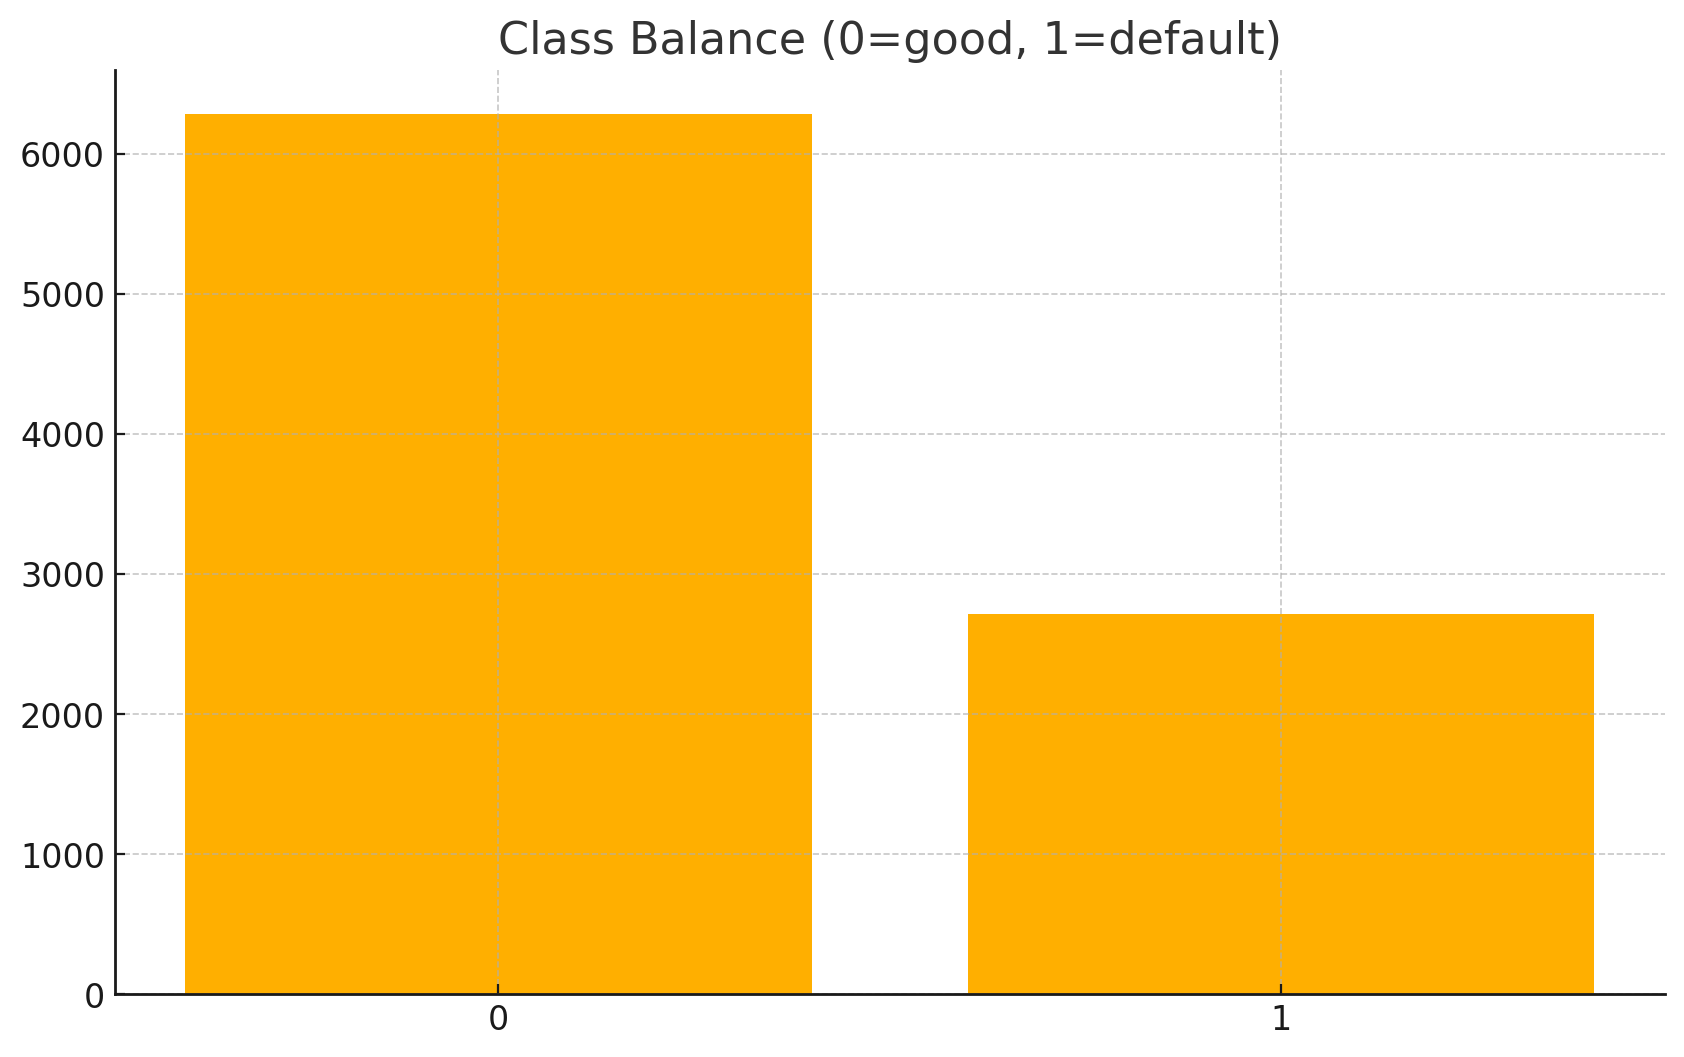

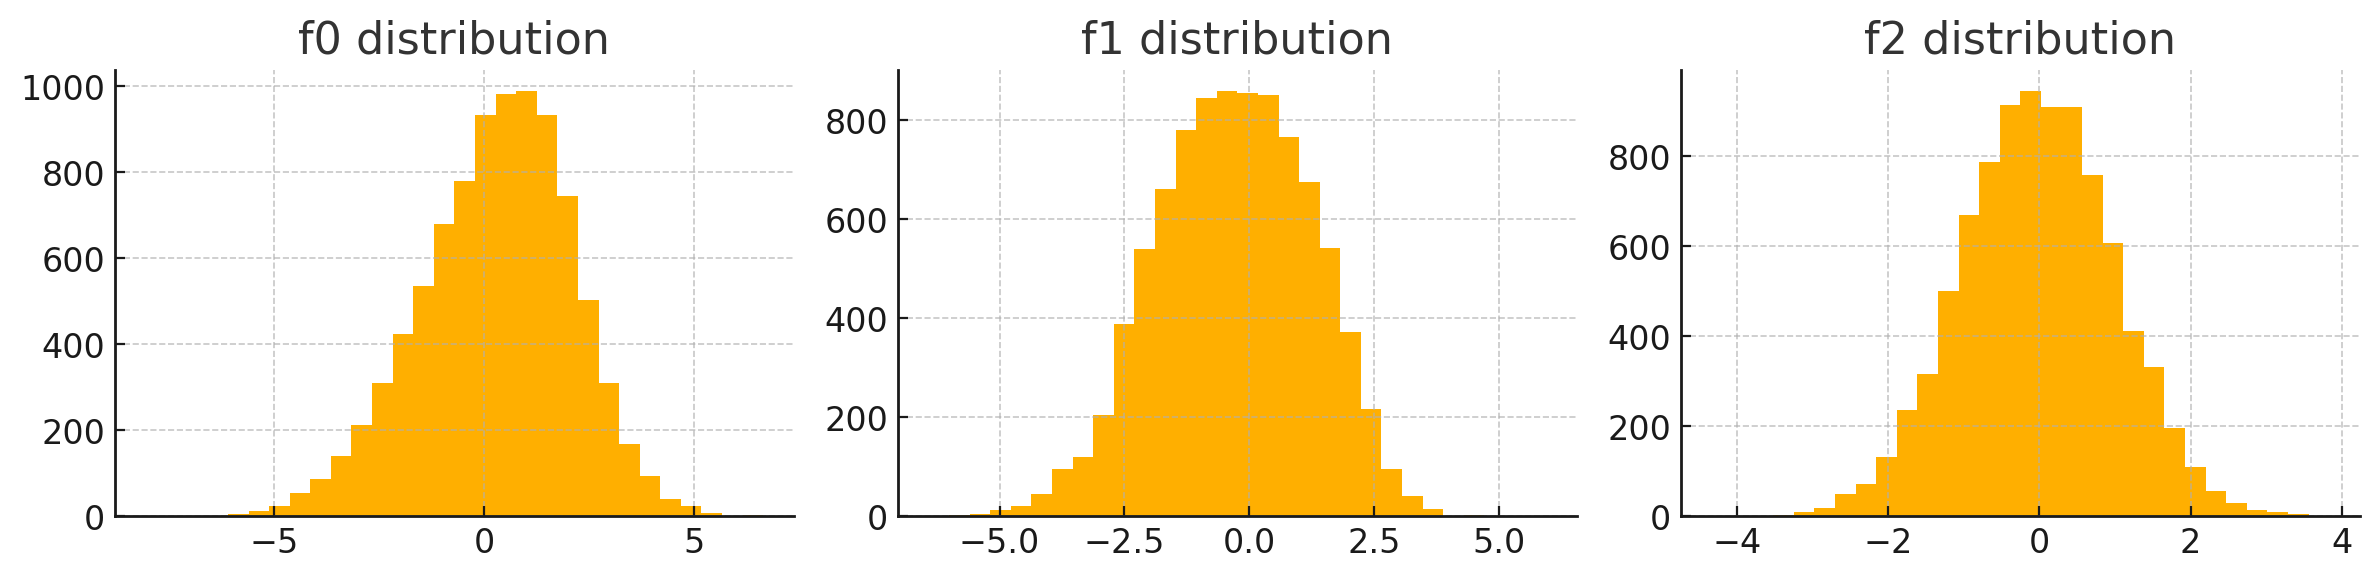

In [2]:

counts = df['default'].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Balance (0=good, 1=default)"); plt.show()

fig, axes = plt.subplots(1,3, figsize=(12,3))
for ax, c in zip(axes, ['f0','f1','f2']):
    ax.hist(df[c], bins=30); ax.set_title(f"{c} distribution")
plt.tight_layout(); plt.show()


### 2) Train/test and model

In [3]:

X = df.drop(columns=['default']).values
y = df['default'].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]
print("ROC AUC:", round(roc_auc_score(yte, proba),4))


ROC AUC: 0.8968


### 3) ROC & PR curves

<Figure size 1200x800 with 0 Axes>

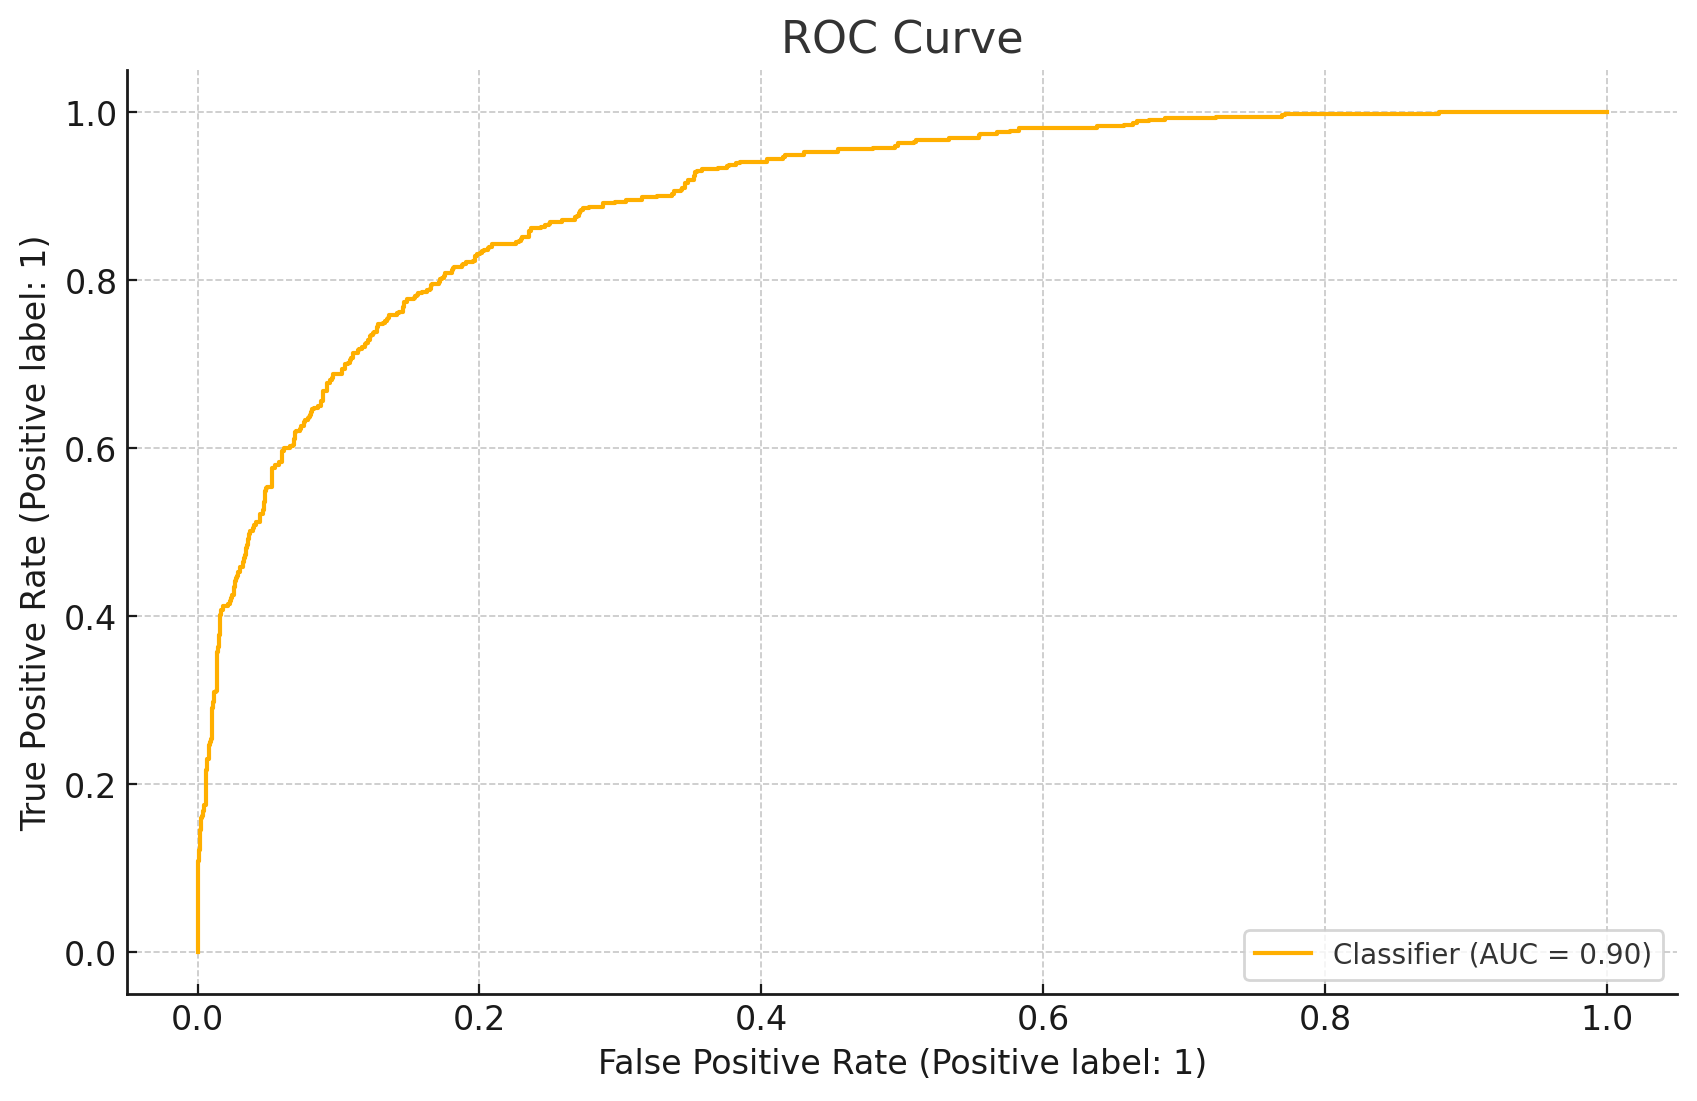

<Figure size 1200x800 with 0 Axes>

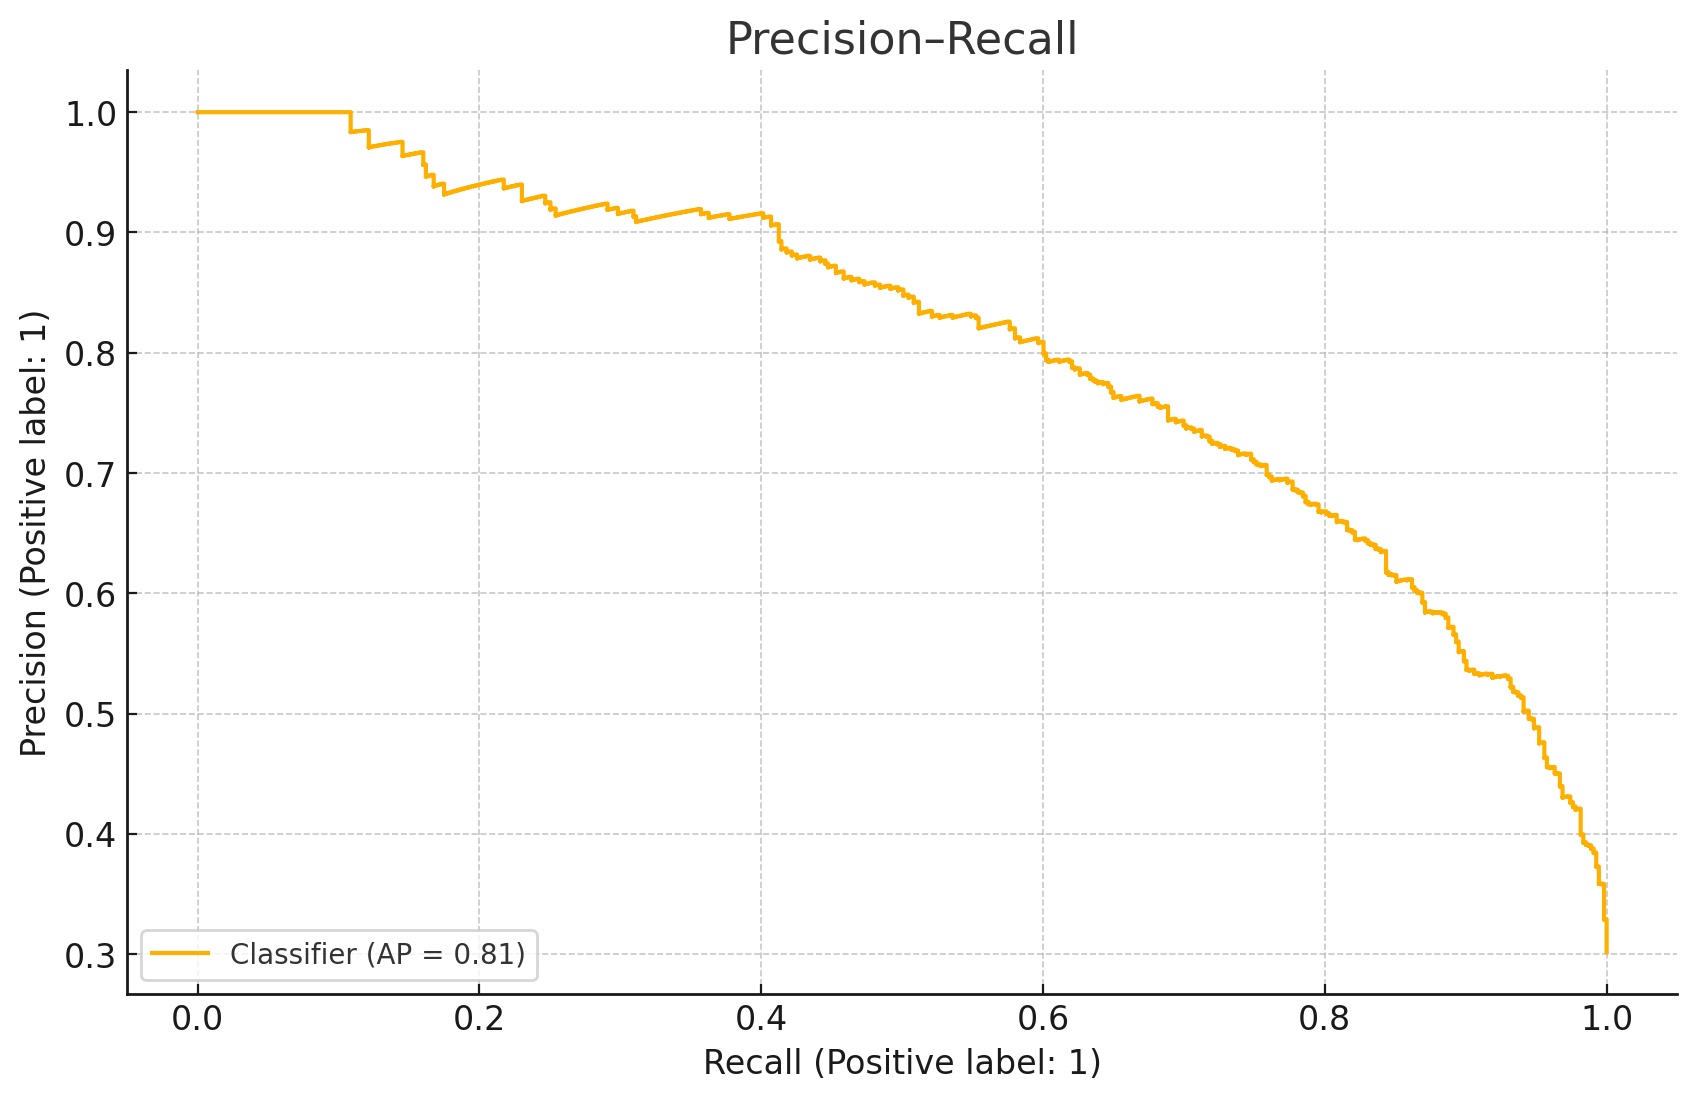

In [4]:

plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(yte, proba); plt.title("ROC Curve"); plt.show()

plt.figure(figsize=(6,4))
PrecisionRecallDisplay.from_predictions(yte, proba); plt.title("Precision–Recall"); plt.show()


### 4) Cost curve & optimal threshold
Assume costs: FP=$1500 (approve defaulter), FN=$5000 (reject good or miss defaulter depending on policy).

Best threshold: 0.302 | Min cost: 825500.0


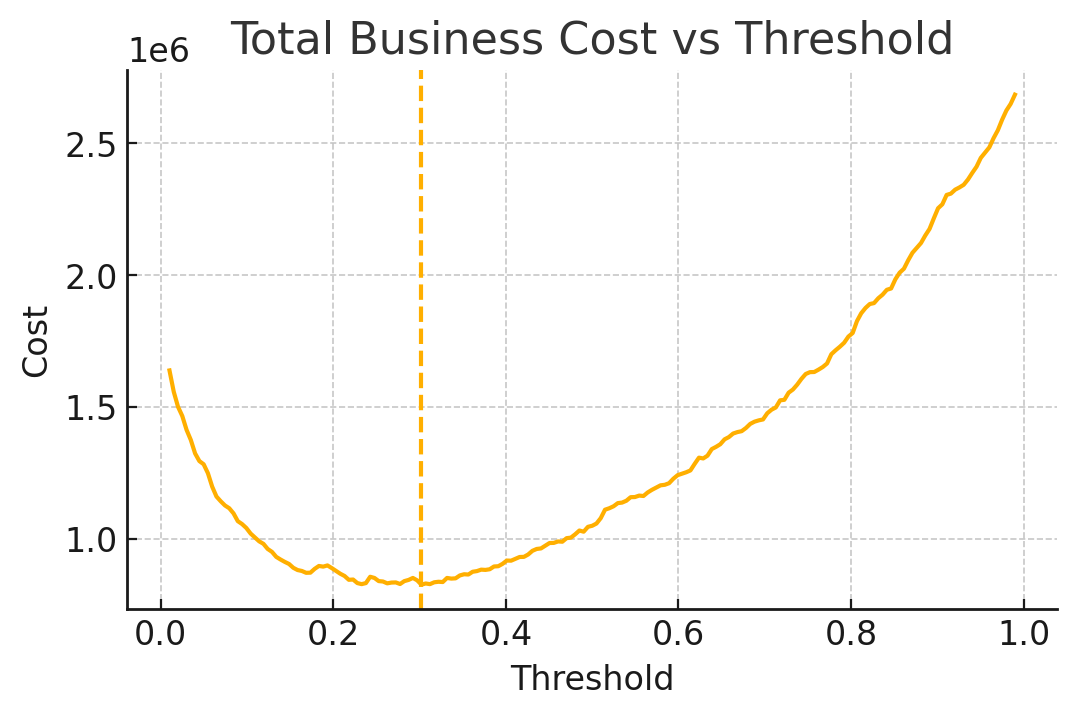

In [5]:

COST_FP, COST_FN = 1500.0, 5000.0
def total_cost(y_true, y_proba, thresh):
    y_pred = (y_proba >= thresh).astype(int)
    fp = ((y_true==0)&(y_pred==1)).sum()
    fn = ((y_true==1)&(y_pred==0)).sum()
    return fp*COST_FP + fn*COST_FN

ths = np.linspace(0.01,0.99,199)
costs = np.array([total_cost(yte, proba, t) for t in ths])
best_t = ths[np.argmin(costs)]; best_cost = costs.min()
print("Best threshold:", round(best_t,3), "| Min cost:", round(best_cost,2))

plt.figure(figsize=(6,3.5))
plt.plot(ths, costs); plt.axvline(best_t, linestyle='--')
plt.title("Total Business Cost vs Threshold"); plt.xlabel("Threshold"); plt.ylabel("Cost"); plt.show()


### 5) Metrics vs threshold (Precision/Recall)
Visualizes trade-off as threshold moves.

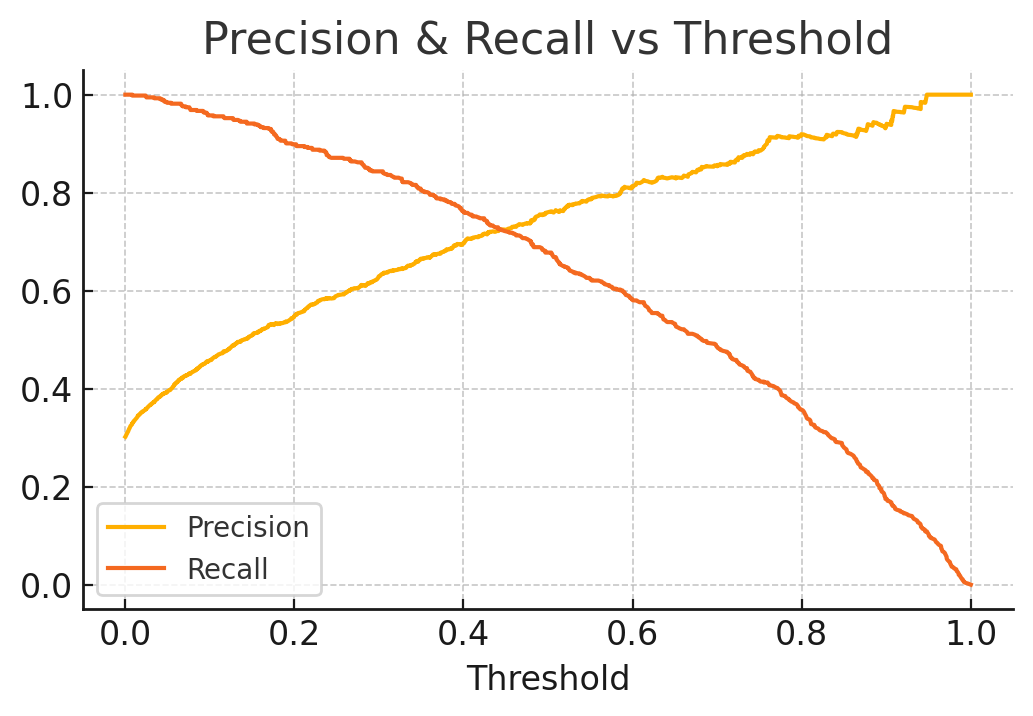

In [6]:

prec, rec, thresh = precision_recall_curve(yte, proba)
# Extend to match lengths
th = np.concatenate([thresh, [1.0]])
prec_ext = np.concatenate([prec, [prec[-1]]])
rec_ext  = np.concatenate([rec,  [rec[-1]]])
n = min(len(th), len(prec_ext), len(rec_ext))
plt.figure(figsize=(6,3.5))
plt.plot(th[:n], prec_ext[:n], label="Precision")
plt.plot(th[:n], rec_ext[:n],  label="Recall")
plt.legend(); plt.title("Precision & Recall vs Threshold"); plt.xlabel("Threshold"); plt.show()


### 6) Confusion matrix at optimal threshold

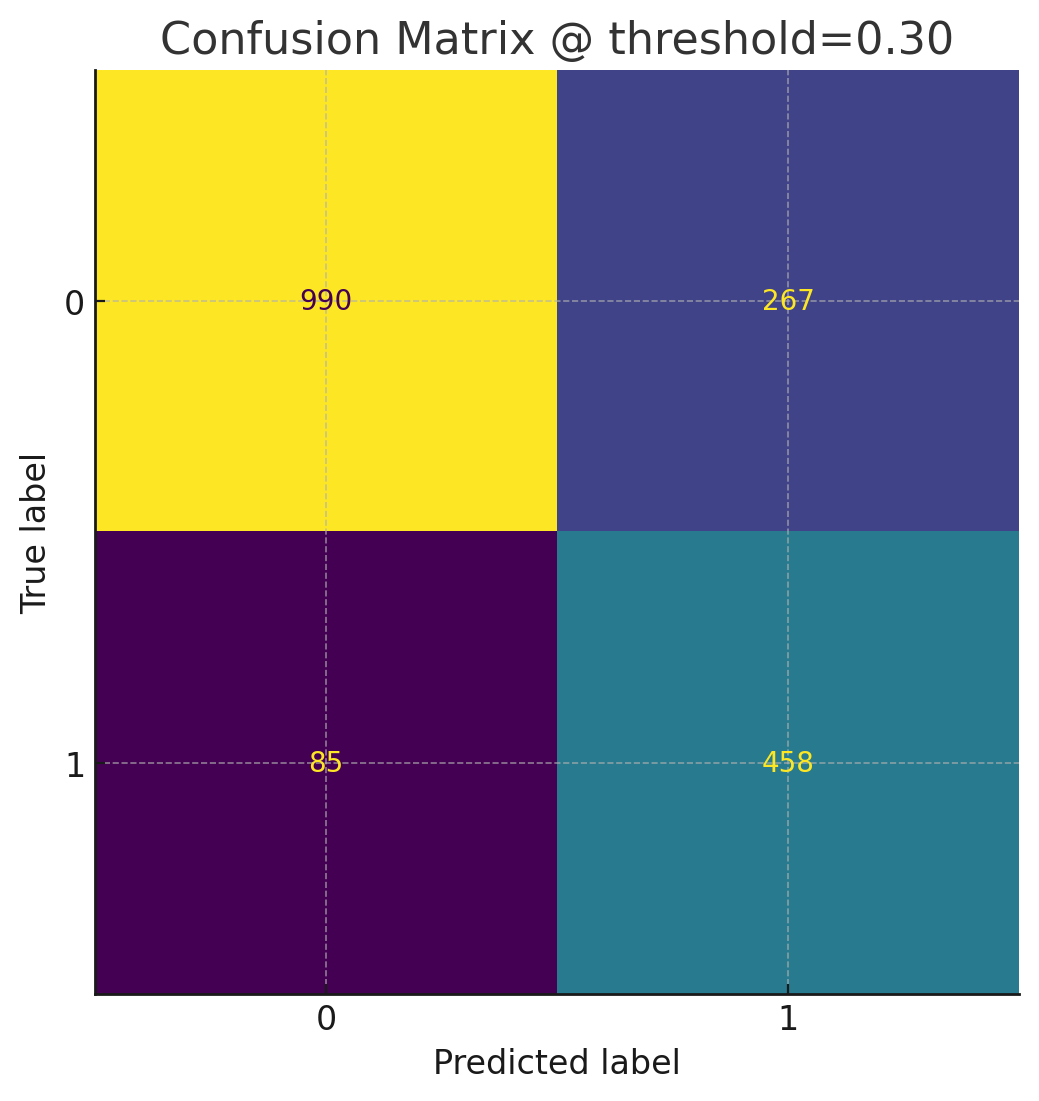

In [7]:

y_hat = (proba>=best_t).astype(int)
ConfusionMatrixDisplay.from_predictions(yte, y_hat, colorbar=False)
plt.title(f"Confusion Matrix @ threshold={best_t:.2f}"); plt.show()
